### Contact on balls outside strike zone

$$\text{inv_path} = \left(1-\frac{\text{path}}{\text{batter_multiplier}}\right) \times (1+0.2 \times \text{batter_vibes})$$

$$\text{ballpark_sum} = \frac{(\text{fort} - 0.5) + 3 \times (\text{visc} - 0.5) - 6 \times (\text{fwd} - 0.5)}{10}$$

$$\text{threshold}_{\text{s12s13}} = 0.35 - 0.1 \times \text{ruth} + 0.4 \times \text{inv_path} ^ {1.5} + 0.14 \times \text{ballpark_sum}$$

$$\text{threshold}_{\text{s14s15}} = 0.4 - 0.1 \times \text{ruth} + 0.35 \times \text{inv_path} ^ {1.5} + 0.14 \times \text{ballpark_sum}$$


$\text{ruth}$ is standard pitcher ruthlessness with 20% vibes and multiplier.

In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE
from csv_dtypes import column_dtypes
all_files = glob.glob("../roll_data/*-contact.csv")

df = pd.concat((pd.read_csv(f, dtype=column_dtypes) for f in all_files), ignore_index=True)

seasons = [11, 12, 13, 14]
df = df[df['season'].isin(seasons)]
len(df)

411000

In [2]:
df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
df.loc[df["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0
df.loc[df["fielder_mods"].astype(str).str.contains("SCATTERED"), "fielder_vibes"] = 0

In [3]:
dfc = df.copy()
dfc = dfc[dfc["is_strike"] == False]

dfc = dfc[~((dfc["season"] == 11) & (dfc["day"] == 98))] # bad data here

for exclude_mod in ["GROWTH", "TRAVELING", "SHELLED", "CHUNKY", "SMOOTH"]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["fielder_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

dfc = dfc[~(dfc["batting_team_mods"].astype(str).str.contains("O_NO") & (dfc["ball_count"] == 0))]

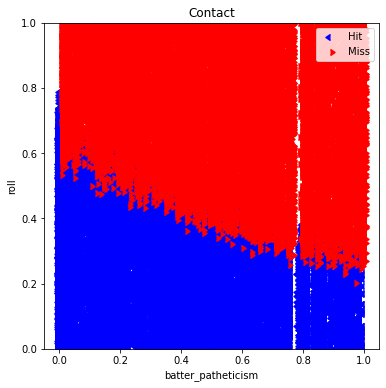

In [4]:
x_val = "batter_patheticism"
y_val = "roll"
fig, ax = plt.subplots(1, figsize=(6, 6))
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]][y_val],
    color="blue",
    label="Hit",
    marker=CARETLEFTBASE,
)
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]][y_val],
    color="red",
    label="Miss",
    marker=CARETRIGHTBASE,
)

ax.set_xlabel(x_val)
ax.set_ylabel("roll")
ax.set_title(f"Contact")
ax.set_ylim(0, 1)

if x_val == "threshold":
    ax.plot(ax.get_xlim(), ax.get_xlim())

ax.legend()

In [5]:
dfc["inv_path"] = (1 - (dfc["batter_patheticism"] / dfc["batter_multiplier"])) * (1 + 0.2*dfc["batter_vibes"])
# dfc.loc[dfc["inv_path"]< 0, "inv_path"] = 0
dfc["inv_path_pow"] = (dfc["inv_path"] ** 1.5)
dfc["ruth"] = dfc["pitcher_ruthlessness"] * (1 + 0.2*dfc["pitcher_vibes"]) * dfc["pitcher_multiplier"]

dfc["grand_center"] = dfc["ballpark_grandiosity"] - 0.5
dfc["fort_center"] = dfc["ballpark_fortification"] - 0.5
dfc["obt_center"] = dfc["ballpark_obtuseness"] - 0.5
dfc["om_center"] = dfc["ballpark_ominousness"] - 0.5
dfc["inc_center"] = dfc["ballpark_inconvenience"] - 0.5
dfc["visc_center"] = dfc["ballpark_viscosity"] - 0.5
dfc["fwd_center"] = dfc["ballpark_forwardness"] - 0.5
dfc["myst_center"] = dfc["ballpark_mysticism"] - 0.5
dfc["elong_center"] = dfc["ballpark_elongation"] - 0.5

dfc.loc[dfc["season"] == 11,"inv_path_pow_season"] = dfc["inv_path_pow"] * 0.4
dfc.loc[dfc["season"] == 12,"inv_path_pow_season"] = dfc["inv_path_pow"] * 0.4
dfc.loc[dfc["season"] == 13,"inv_path_pow_season"] = dfc["inv_path_pow"] * 0.35
dfc.loc[dfc["season"] == 14,"inv_path_pow_season"] = dfc["inv_path_pow"] * 0.35

dfc["ballpark_sum"] = (dfc["fort_center"] + 3*dfc["visc_center"] - 6*dfc["fwd_center"]) / 10

# we know the intercept is 0.4 in s12/s13 and 0.35 in s14/s15 so special case it here so the fit works across
dfc.loc[dfc["season"] == 13,"roll"] -= 0.05
dfc.loc[dfc["season"] == 14,"roll"] -= 0.05

In [6]:
dfc.loc[dfc["inv_path"] < 0, [
        "passed",
        # "offset",
        "roll",
        # "threshold",
        "inv_path",
        "ruth",

        "ballpark_sum",
        # "event_type",
        # "weather",
        # "batter_laserlikeness",
        # "pitcher_multiplier",
        "batter_multiplier",
        "batter_name",
        # "pitcher_name",
        "batter_mods",
        # "pitcher_mods",
        "batting_team_mods",
        # "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
        # "fielder_roll",
    ]]

,passed,roll,inv_path,ruth,ballpark_sum,batter_multiplier,batter_name,batter_mods,batting_team_mods,season,day,game_id,play_count


In [7]:
X = dfc[
    [
        "roll",
        "season",
        "passed",
        "inv_path_pow_season",
        "ruth",

        "ballpark_sum",
    ]
].copy()

X = X[~X["inv_path_pow_season"].isna()].copy()

pin_intercept = None
pin_intercept = 0.35
pins = [
    (-0.1, "ruth"),
    (1, "inv_path_pow_season"),
    (0.14, "ballpark_sum"),
]
for val, var in pins:
    X["roll"] -= X[var] * val
    X = X.drop(var, axis=1)

y = X["passed"]
X = X.drop(["passed", "season"], axis=1)

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model


sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:,0] -= pin_intercept / sc.scale_[0]

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=100000000, tol=1e-12, fit_intercept=pin_intercept is None).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
print(trainedsvm.score(X2, y))

[[44746     0]
 [    0 37424]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     44746
        True       1.00      1.00      1.00     37424

    accuracy                           1.00     82170
   macro avg       1.00      1.00      1.00     82170
weighted avg       1.00      1.00      1.00     82170

1.0


In [9]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_# - np.dot(coef, sc.mean_)
intercept_scaled = pin_intercept or -(intercept / coef[0, 0])[0]

dfc["threshold"] = intercept_scaled
print("intercept:", intercept_scaled)
for pair in pins + list(zip(-np.array(coef_list), X.columns)):
    if pair[1] != "roll":
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]


intercept: 0.35
(-0.1, 'ruth')
(1, 'inv_path_pow_season')
(0.14, 'ballpark_sum')


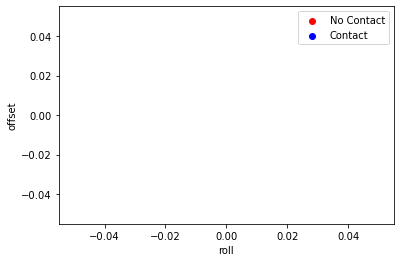

In [10]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]

fig, ax = plt.subplots(1)
x_val = "roll"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="No Contact",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Contact",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

In [11]:
pd.set_option("display.max_columns", None)
table = outliers[
    [
        "passed",
        "offset",
        # "event_type",
        # "weather",
        # "batter_laserlikeness",
        "roll",
        "threshold",
        "pitcher_multiplier",
        "batter_multiplier",
        "fielder_multiplier",
        "batter_name",
        "pitcher_name",
        "fielder_name",
        "batter_mods",
        "pitcher_mods",
        "fielder_mods",
        "batting_team_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
        # "fielder_roll",
    ]
]
print(len(table))
table.sort_values("offset", ascending=False)#[0:10]

0


,passed,offset,roll,threshold,pitcher_multiplier,batter_multiplier,fielder_multiplier,batter_name,pitcher_name,fielder_name,batter_mods,pitcher_mods,fielder_mods,batting_team_mods,pitching_team_mods,season,day,game_id,play_count
